***Import Libraries***

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk
import datetime
%matplotlib inline

from scipy.spatial.distance import euclidean
from sklearn.svm import OneClassSVM
from sklearn.cluster import MiniBatchKMeans
from luminol import *
from luminol.modules.time_series import TimeSeries
from luminol.anomaly_detector import AnomalyDetector

---

***Recreating USPS Nearest-Neighbors Martingales from "Testing Exchangeability On-Line" (Vovk)***


Our goal here was to re-create the analysis done in Vovk's "Testing Exchangeability On-Line". We used the same dataset used in their paper. The data set contains image data of distinct handwritten digits and was generated from mail data provided by the United States Postal Service. As part of a study in the 1990s, the USPS and researchers hired contractors to identify categorize 9,282 separate digits, 0 to 9, written on mail. The image of each digit was stored in the form of 256 pixels (16x16). 

We were able to find the data here: http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass.html#usps. The data is separated into training and testing sets, but we combined them into one data set similar to Vovk. Our "x" data contains the image data of the 256 pixels. Our "y" data contains the categorized digit (0-9).

Our anomaly functions below receive data in time-series fashion --- one sample at a time. Since our data set is known to be heterogeneous, it's useful for detecting anomalies as we would expect it not to be exchageable. 

Given the size of the data set, we were only able to run our martingale function on a subset of the data: the first 500 points. As shown below, however, we were able to repoduce the results in Vovk.

**FUNCTION: Strangeness - Nearest-Neighbor Method**

The "strangeness function" is used to determine how different a given sample is from other samples with the same label. As we receive data one-sample at a time, we compare a given sample to the *previous samples only*. 

The method we use below mimics that of Vovk: the Nearest Neighbor method. For each sample in sequence, we calculate the ratio between the:
- Minimum euclidian distance between the sample and all previous samples with the *same label*; and the
- Minimum euclidian distance between the sample and all previous samples with a *different label*.

In other words, we're determining strangeness by seeing (1) how different our sample is from samples with the same label and (2) how similar our sample is to points with a different label.

In [2]:
# FXN:  inputs: x and y datasets, starting point in dataset to begin analysis, and the ending point where we stop our analysis
#       output: array of strangeness values for each sample

def strangeness_nn(x, y, start_point, end_point):

    n = len(x)
    num_array = []    # make blank arrays for storing distance values below 
    denom_array = []
    
    if start_point == 0:   # can not determine eucl. distance with only one point.
        start_point = 1
    
    # iterate through each sample in sequence, our "target" sample
    for i in range(start_point, end_point):

        min_dist_num = 100000      # set high starting minimum distance values 
        min_dist_denom = 100000


        # iterate through every sample in sequence receive prior to the "target" sample
        for j in range(0, i):

            # if "target" sample has the same label...
            if y.iloc[i] == y.iloc[j]:

                # ...calculate the euclidian distance...
                dist_num = euclidean(x.iloc[i, :], x.iloc[j, :])

                #...and store value if it's the smallest distance calculated so far. 
                if dist_num < min_dist_num:
                    min_dist_num = dist_num
                    
            # if "target" sample has different label...
            elif y.iloc[i] <> y.iloc[j]:

                # ...calculate the euclidian distance...
                dist_denom = euclidean(x.iloc[i, :], x.iloc[j, :])

                #...and store value if it's the smallest distance calculated so far.
                if dist_denom < min_dist_denom:
                    min_dist_denom = dist_denom

        # store same-label minimum distances and different-label minimum distances into arrays  
        num_array.append(min_dist_num)
        denom_array.append(min_dist_denom)

    # compute our strangeness array with stored values
    strangeness_array = np.divide(num_array, denom_array)
    
    # return strangeness array
    return strangeness_array

**FUNCTION: Calculate p-values of Strangeness Array** 

Next, we calculate our "p-values" per the Vovk paper. The p-value determines relative strangeness: the strangeness a given sample compared to the strangeness of previous samples. Given a sample, we count the number of times this sample has a lower strangeness value than previous samples' strangeness values. Then, we divide this by the number of samples we've received.

In [3]:
# FXN:  input: array of strangeness values for each sample
#       output: array of p-values for each sample

def p_values(strangeness_array):

    p_val_array = [1]  # set initial p-value to 1
    
    
    # iterate through each "target" sample in strangeness array
    for i in range(1, len(strangeness_array)):

        count = 0.0    #set initial count to zero

        # for each "target" sample, iterate through all previous strangeness points...
        for j in range(0, i):

            # each time the "target" sample's strangeness is less than a previous sample's strangeness...
            if strangeness_array[i] < strangeness_array[j]:
                
                # increase count by 1
                count = count + 1.

        # per paper, p-val is #{i: αi ≥ αn} / n  --- strangeness at n is less than or equal to prev samples INCLUDING at n.
        p_val = (count + 1) / (i + 1)  

        # add p-value to our array
        p_val_array.append(p_val)
        
    # return the array of p-values
    return p_val_array

**FUNCTION: Calculate Martingale Values**

Finally, we calculate our martingale values. The martingale function is cumulative in nature, as each martingale value is calculated by multiplying a sample's relative strangeness (p-value) every previous samples' p-values. A tuning paramter, epsilon, is incorporated into this function to both yield better results and normalize our data.

It's worth noting that because of the manner in which epsilon "tunes" our values below (p-values to the *power* of 1 minus epsilon), Vovk describes these martingales as "Power Martingales."

In [4]:
# FXN:  input: p-values of samples and tuning parameter, epsilon
#       output: array of martingale values

def martingale_values(p_val_array, epsilon):

    martingale_array = [1]    # set initial value to 1

    # iterate through each p-value
    for i in range(1, len(p_val_array)):

        # calculate the "target" sample's individual martigale value based on it's p-value and our tuning parameter
        martingale_at_i = epsilon * (p_val_array[i] ** (epsilon - 1))

        # multiply the "target" sample's value by the previous value in the martingale array
        martingale_val = martingale_at_i * martingale_array[i - 1]

        # store this value in the martingale array
        martingale_array.append(martingale_val)
    
    #return array of martingale values
    return martingale_array

**LOAD & CLEAN USPS DATA**

NOTE: Data sets downloaded from link above were very clean. Only minor formatting was needed (in Excel) before loading data.

In [5]:
# load training and testing sets
train = pd.read_csv('usps_train.csv')
test = pd.read_csv('usps_test.csv')

# per Vovk, combined training and testing data sets
data = pd.concat((train, test), axis=0)

# make x- and y- arrays
y = data.iloc[:, -1]
x = data.iloc[:, :-1]

**RUN MARTINGALE FUNCTIONS**

In order to replicate Vovk's output in figure 1, we need to:
1. Run our data through the strangeness and p-value functions above;
2. Create range of epsilon values between 0 and 1 (for x-axis)
3. Run our martingale function for each epsilon value
4. For each epsilon value, calculate the log (base 10) of the *final* martingale value (for y-axis)

As the martingale output is cumulative, we are concerned with the *final* value of each martingale for a given epsilon. 

In [6]:
# establish starting and ending points on data sets for analysis
start_point = 100
end_point = 500

# run USPS dataset through functions above
strangeness_array_nn = strangeness_nn(x, y, start_point, end_point)
p_val_array_nn = p_values(strangeness_array_nn)

In [7]:
# create array of epsilon values between 0 and 1
epsilon_range = np.arange(0, 1.01, 0.1)

# set first value to 0.01 (can't be zero because we're taking the log later...)
epsilon_range[0] = 0.01

# create array to store values for y-axis
log_final_mart_array = []

# iterate through each epsilon value
for i in range(0, len(epsilon_range)):

    # run the martingale function for each epsilon
    martingale_array_nn = martingale_values(p_val_array_nn, epsilon_range[i])
    
    # compute the log (base 10) of the final value in the martingale array
    log_final_mart_val = np.log10(martingale_array_nn[-1])

    # store this value into an array (for our y-axis below)
    log_final_mart_array.append(log_final_mart_val)

**COMPARE OUR NN POWER MARTINGALES TO VOVK**

To compare our methods, we graph our results just as in Figure 1 of the Vovk paper: x = epsilon value range; y = log of final martingale value.

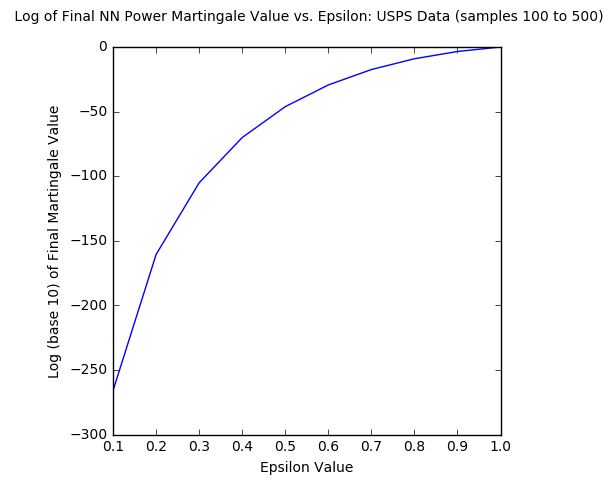

In [8]:
# create plot
fig, ax = plt.subplots(figsize=(5,5))

# plot our epsilon range versus the log of our final martingale values
ax.plot(epsilon_range, log_final_mart_array)

# set chart attributes
ax.set_title(' Log of Final NN Power Martingale Value vs. Epsilon: USPS Data (samples ' + str(start_point) + ' to ' + str(end_point) + ')', fontsize=10)
ax.set_xlabel('Epsilon Value')
ax.set_ylabel('Log (base 10) of Final Martingale Value')
ax.title.set_position([.5, 1.05])

# show plot
plt.show()

**VOVK FIGURE 1 - NN Power Martingales as Function of Epsilon: Full USPS Dataset**

<img style="float: left;" src="vovk_fig1.jpg">

***Discussion***

We were able to successfully implement the Nearest-Neighbor Power Martingale as outlined in the Vovk paper. Although we were only able to use a subset of the data, directionally our results are identical. As we increase our subset range, our initial martingale values start from a lower value and asymptomatically approach zero.

---

***Luminol Anomaly Detection Package***

The python luminol package contains a simple anomaly detection algorithm: https://pypi.python.org/pypi/luminol/. It computes a value proportional to the absolute value of the first derivate of the underlying sample. Thus, a sudden change in our underlying sample data will yield spikes in the luminol algorithm.

Below we test this package on three time-series data sets: Daily S&P 500 index, Annual Change in Earth's Rotation, and Annual Rainfall in Fortaleza, Brazil. While these are simple 1-dimensional datasets, this method for detecting anomalies proves effective. This is especially evident in the S&P 500 index where spikes in our anomaly algorithm occur at known, drastic market events: the crash of 1987, the dot.com bubble, the Great Recession. 



**FUNCTION: Detect Anomalies in Data Using Luminol Package**

In [9]:
# FXN:  input: time-series data, y
#       output: anomaly index

def anomaly_detector(y):
    
    # convert y-values to dictionary object and...
    y_dict = y.to_dict()
    
    # ...convert to luminol TimeSeries object
    ts = TimeSeries(y_dict)

    # run luminol's AnomalyDetector on time-series data
    anomaly_dect = AnomalyDetector(ts, algorithm_name='derivative_detector')
    
    # get anomaly index scores
    scores = anomaly_dect.get_all_scores().values
    
    # return anomaly index scores
    return scores

**FUNCTION: Plot Anomalies & Underlying Time-Series Data**

In [10]:
# FXN:  input: time axis (x), time-series data (y1), anomaly index scores (y2), and attributes for chart labelling and scaling
#       output: chart with two y-axes, left for underlying data and right for anomaly index

def plot_anomalies(time_axis, time_series_data, anom_scores, anom_min, anom_max, y_label, title):

    # create plot
    fig, ax1 = plt.subplots(figsize=(8,5))

    # create y2 axis with same x-axis
    ax2 = ax1.twinx()
    
    # plot underlying data and anomaly index versus over time
    ax1.plot(time_axis, time_series_data, 'g-')
    ax2.plot(time_axis, anom_scores, 'b-')
    
    # set chart attributes
    ax1.set_title(title)
    ax1.title.set_position([.5, 1.05])
    ax1.set_xlabel('Year')
    ax1.set_ylabel(y_label, color='g')
    ax2.set_ylabel('Anomaly Score', color='b')
    ax2.set_ylim([anom_min, anom_max])

    # display chart 
    plt.show()

**LOAD DATA & PLOT ANOMALIES: S&P 500 Index per Year**

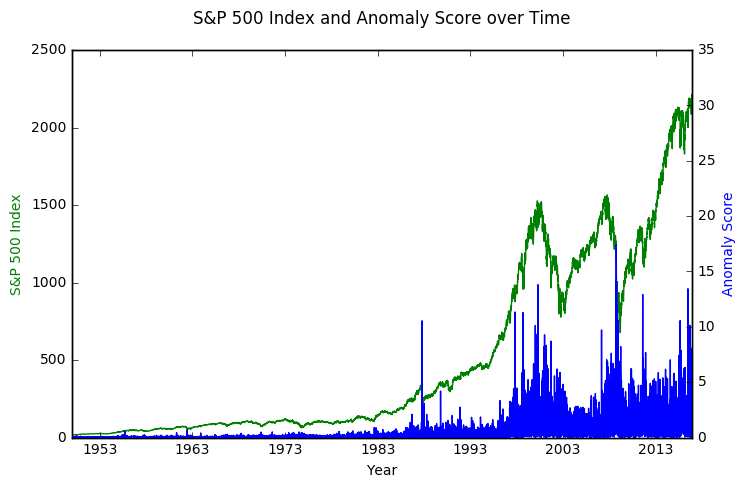

In [11]:
#load data
df_raw_SPX = pd.read_csv('SPX_010350_120516.csv')

# raw data is in reverse-chronological order...so reverse the entire data set
df_SPX = df_raw_SPX.iloc[::-1]
df_SPX.reset_index(drop=True, inplace=True)

# create time axis and convert to datetime format for graphing purposes
date_raw_SPX = df_SPX.iloc[:, 0]
date_SPX = pd.to_datetime(date_raw_SPX)

# create x- and y- datasets
x_SPX = df_SPX.iloc[:,1:-1];
y_SPX = df_SPX.iloc[:,-1];

# run anomaly_detector function on our y-values
scores_SPX = anomaly_detector(y_SPX)

# generate plot using function above
plot_anomalies(date_SPX, y_SPX, scores_SPX, 0, 35, 'S&P 500 Index', 'S&P 500 Index and Anomaly Score over Time')

**LOAD DATA & PLOT ANOMALIES: Increase of Length of Earth-Day per Year (in microseconds)**

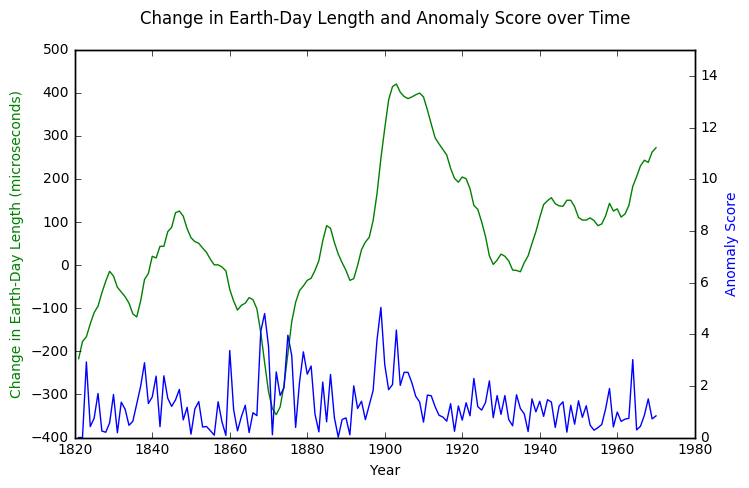

In [12]:
# load data
df_EARTH = pd.read_csv('earth_day_change_per_year_1821_1970.csv')

# get years array associated with dataset
date_EARTH = df_EARTH.iloc[:, 0]

# create x- and y- datasets
x_EARTH = df_EARTH.iloc[:,1:-1];
y_EARTH = df_EARTH.iloc[:,-1];

# run anomaly_detector function on our y-values
scores_EARTH = anomaly_detector(y_EARTH)

# generate plot using function above
plot_anomalies(date_EARTH, y_EARTH, scores_EARTH, 0, 15, 'Change in Earth-Day Length (microseconds)', 'Change in Earth-Day Length and Anomaly Score over Time')

**LOAD DATA & PLOT ANOMALIES: Annual Rainfall in Fortaleza, Brazil (in mm)**

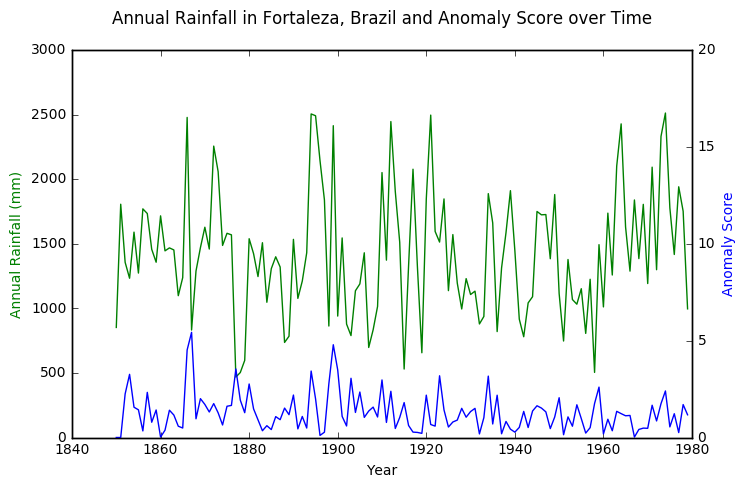

In [13]:
# load data
df_FORTALEZA = pd.read_csv('annual_rainfall_fortaleza_1850_1979.csv')

# get years array associated with dataset
date_FORTALEZA = df_FORTALEZA.iloc[:, 0]

# create x- and y- datasets
x_FORTALEZA = df_FORTALEZA.iloc[:,1:-1];
y_FORTALEZA = df_FORTALEZA.iloc[:,-1];

# run anomaly_detector function on our y-values
scores_FORTALEZA = anomaly_detector(y_FORTALEZA)

# generate plot using function above
plot_anomalies(date_FORTALEZA, y_FORTALEZA, scores_FORTALEZA, 0, 20, 'Annual Rainfall (mm)', 'Annual Rainfall in Fortaleza, Brazil and Anomaly Score over Time')

***Discussion***

The simple Anomaly Detector algorithm in the luminol package is an effective method for detecting anomalies. As shown above, the anomaly index spikes in value where there are drastic changes (up or down) in the underlying data. 

This methodology, however, has it's shortcomings. First, it does not perform well with cyclical data. While not shown above, our attempts as running AnomalyDetector on monthly weather station temperature readings (over several years) provided poor results. This is not surprising, we we would *expect* to see drastic fluctuations in temperature throughout each year --- our AnomalyDetector function captures these flucuations as anomalies. 

Second, this method does not work for high dimensional data as it is only concerned with one-time series output. Lastly, the algorithm only considers the "target" sample value and the previous sample value; it does not consider any other previously received data. While this can be considered a plus if performing anomaly detection "on-line", it does not allow for greater precision or flexibility by taking more prior data into account.

---

**GRAVEYARD**

In [14]:


clf = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(xtrain)
y_pred_train = clf.predict(xtrain)
#y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

NameError: name 'xtrain' is not defined

In [ ]:
# Randomized probability of obtaining set vals given strangeness measure
def pfn(vals, strangeness_fn):
    a_n = strangeness_fn(vals[-1])
    i_greater = 0
    i_equal = 0
    n = len(vals)
    for k in range(0, n-1):
        a_k = strangeness_fn(val[k])
        if a_k > a_n: i_greater += 1
        elif a_k == a_n: i_equal += 1
    theta = np.random.rand()
    pval = (i_greater + theta*i_equal)/n
    retdfurn pval

In [ ]:
# Gaussian kernel for adiabatic incremental SVM
class IncrementalSVM:
    
    def __init__(self, ):
        

In [ ]:
epsilon = 0.92

class RandomizedPowerMartingale:
    
    def __init__(self, pfn, sfn, epsilon):
        self._pfn = pfn
        self._sfn = sfn
        self._epsilon = epsilon
        self._pval_i = 1
        self._m_ip = 1
        self._m_i = 1
        self._i = 0
        
    def stream(self, stream):
        val = stream.next()
        while val is not None:
            self._pval_i = self._pfn(item)
            self._m_ip = self._m_i
            self._m_i *= self._epsilon*self._pval_i**(self._epsilon-1)          
            i += 1
            val = stream.next()
            
    def test1(self, lamb):
        return self._m_i >= lamb
   
    def test2(self, t):
        return abs(self._m_i - self._m_ip) >= t

In [ ]:
# df_cols = list(df_raw.columns.values)

# print df_cols

# np_zeros = np.zeros((df_raw.shape[0], df_raw.shape[1]))

# print np_zeros.shape

# df_blank = pd.DataFrame(np_zeros, columns=df_cols)

# print df_blank.head(5)
# print df_blank.shape

In [ ]:
# n = len(df_raw)

# for i in range(0, n):
    
#     df_blank.iloc[i, :] = df_raw.iloc[(n - i - 1), :]
    
# df = df_blank

# print df.head(5)

In [ ]:
# for a in anoms:
#     end = df.ix[a.start_timestamp,0]
#     start = df.ix[a.end_timestamp,0]

#     print(start + '-' + end + '-' + str(a.anomaly_score))